# How to Capture Real-time Events with Kafka and MongoDB
> Creating kafka cluster and topic on cloud - Creating mongodb cluster and database on cloud - Pre-process movielens data in kafka Json format - Send and receive data events in kafka in real-time - Persist the streaming data in NoSQL mongoDB database.

- toc: true
- badges: false
- comments: true
- categories: [Kafka, MongoDB, RealTime]
- image:

## Introduction

Duration: 5

### What you'll learn?

- Creating kafka cluster and topic on cloud
- Creating mongodb cluster and database on cloud
- Pre-process movielens data in kafka Json format
- Send and receive data events in kafka in real-time
- Persist the streaming data in NoSQL mongoDB database

### Why is this important?

- Real-time capture of event is very important to serve real-time recommendations
- Everything is on cloud
- Free of cost to start with at least (and to run this experiment obviously)

### How it will work?

1. Setup kafka and mongodb clusters
2. Configure the connnections in colab notebooks by saving the right credentials
3. Load and prepare movielens dataset
4. Start Kafka producer, consumer and mongodb listener notebooks
5. Send a record from kafka producer to kafka consumer
6. Save the received record in mongodb
7. Read the record from mongodb stream and convert into pandas dataframe

### Who is this for?

- People who are looking to learn how to stream user behaviour events in real-time
- People who are interested in learning more on kafka and mongodb

### Important resources

- [Notebooks](https://github.com/recohut/reco-static/tree/master/poc/kafka_mongodb_streaming)
- [Video demo](https://youtu.be/AMY-o4ArW7E)

<!-- ------------------------ -->

## Setup Kafka

Duration: 10

### Sign-up

Go to [this](https://customer.cloudkarafka.com/signup) link and signup

### Create a team

Enter a team name and create the team. Below is the settings that I used:

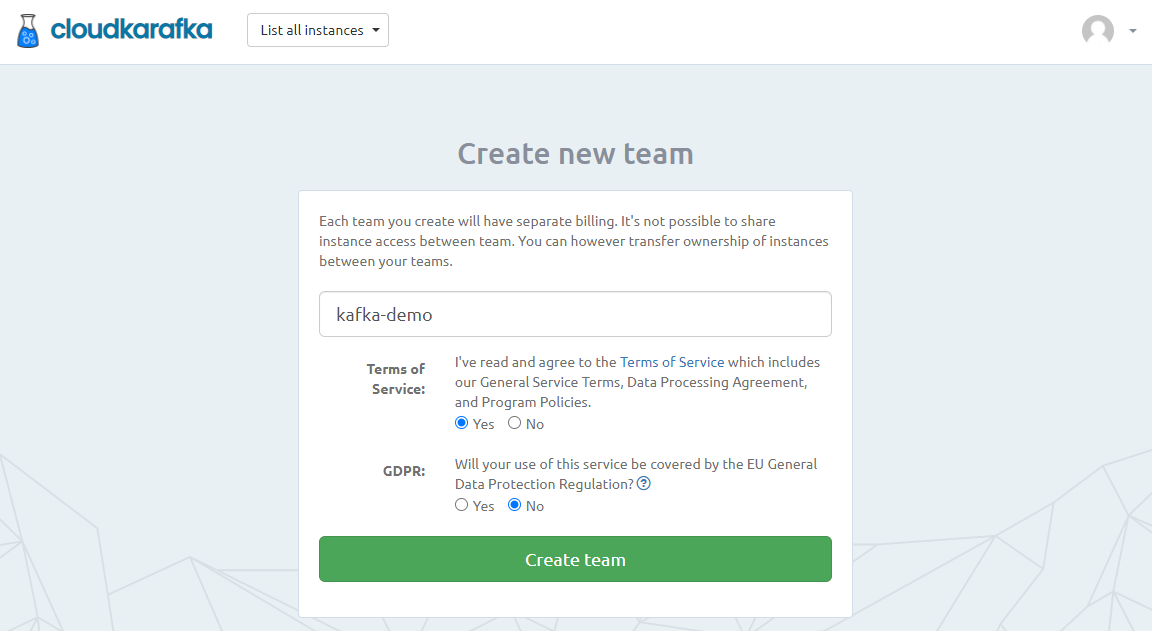

### Create an instance

Click on *Create New Instance* button and fill-out the details. For instance, I filled the below ones in my case:

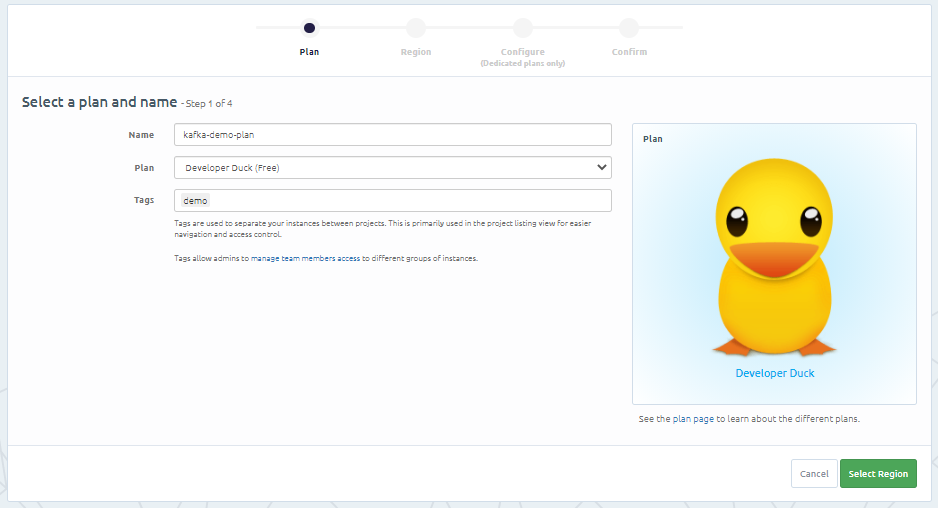

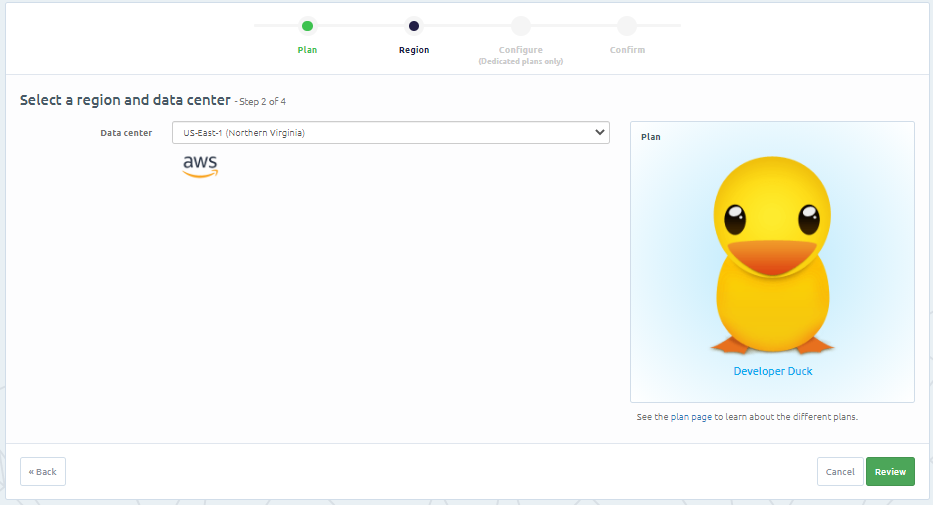

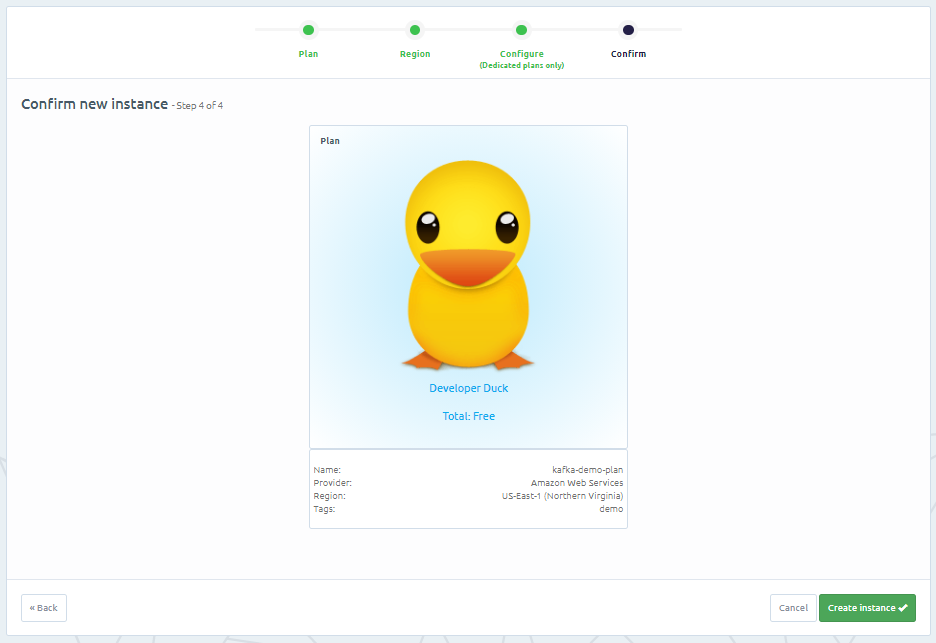

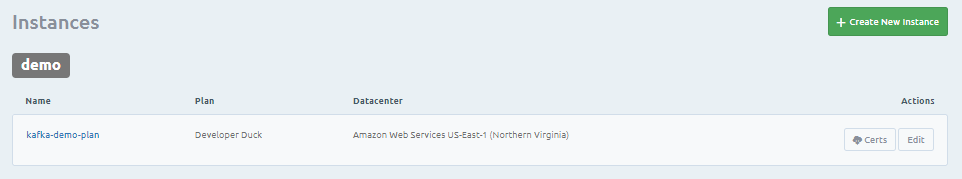

### Create Kafka topic

Click on the kafka instance and you will see something like this:

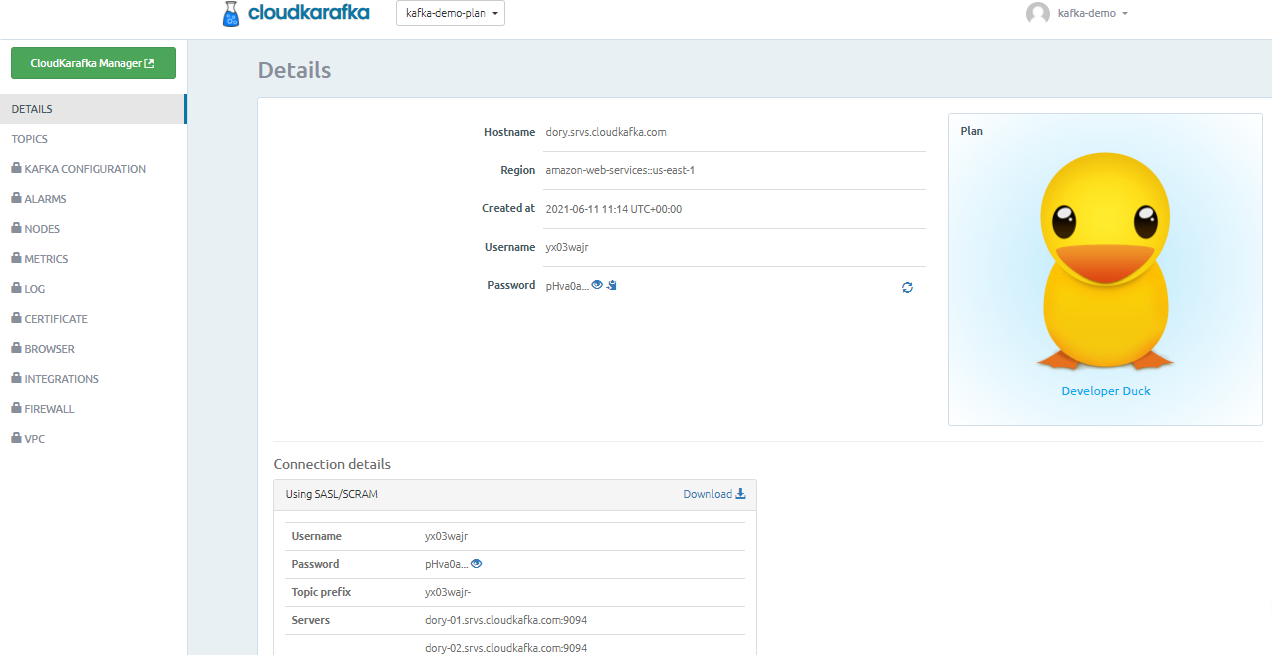

We will be needing these details to configure Kafka in our notebook.

For now, let's create a topic first. Click on topic tab, from left-side navigation pane.

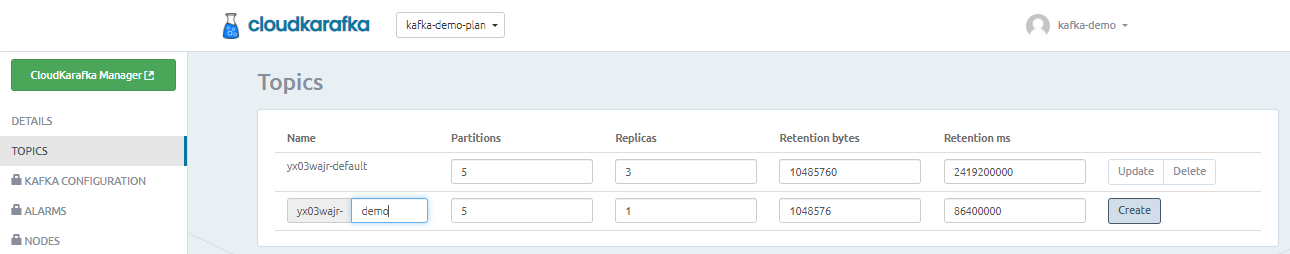

You can use default one also, but for our use case, we are creating a new topic named "<user_name>-<topic_name>".

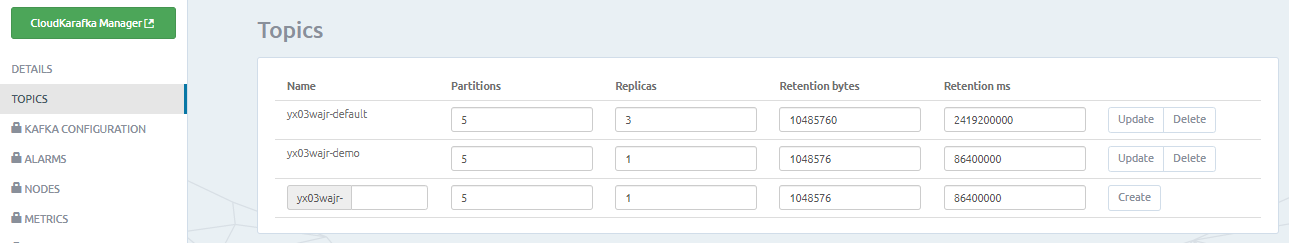

Keep this instance detail page open or note down the details safely. We will be needing these details later.

<!-- ------------------------ -->

## Setup MongoDB

Duration: 10

### Sign up

Go to [this](https://account.mongodb.com/account/register?n=%2Fv2%2F6056079edc5be0371e355b11&nextHash=%23clusters) link and sign-up. I used *Sign up with Google* option.

### Create organization

I got this as my welcome page:



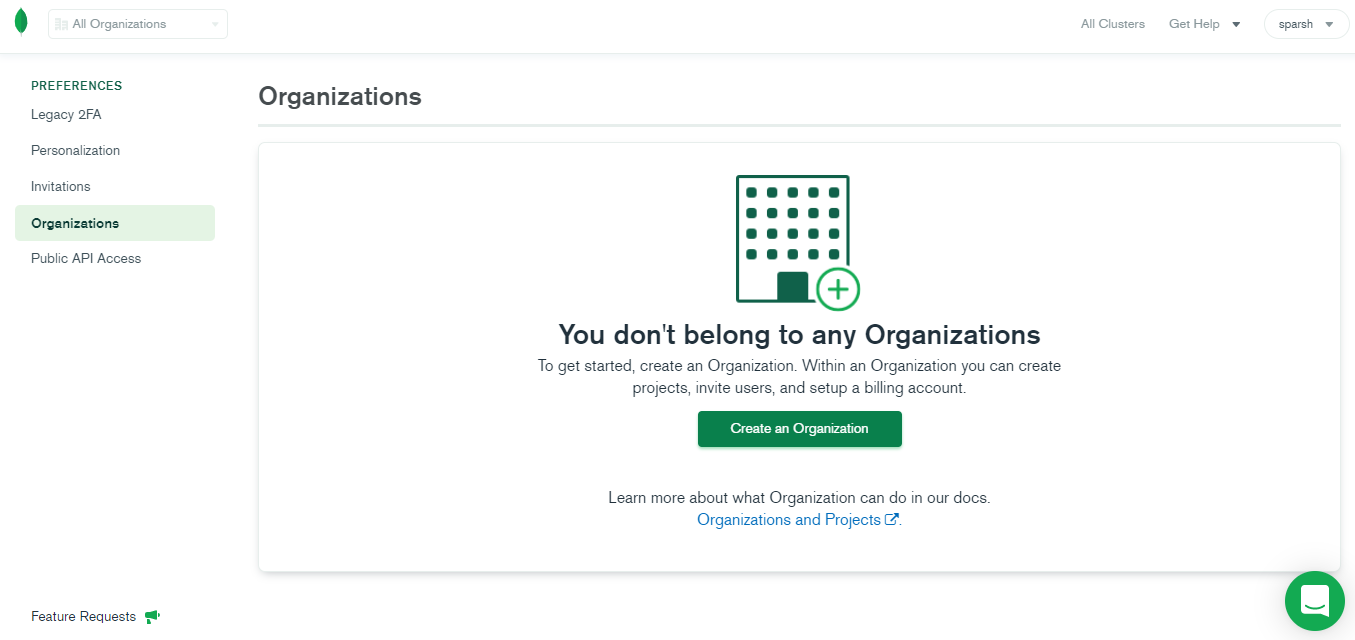

Click on *Create an Organization.* Give it a name and click on *Next:*

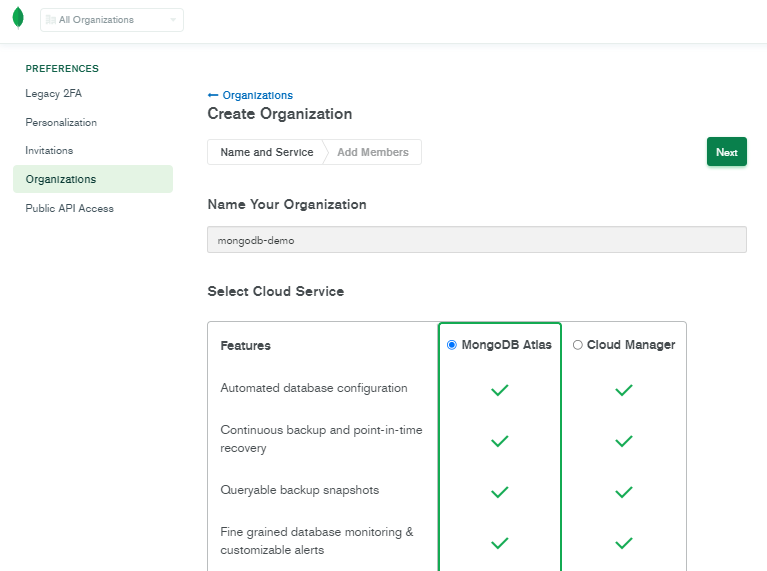

Click on *Create Organization*:

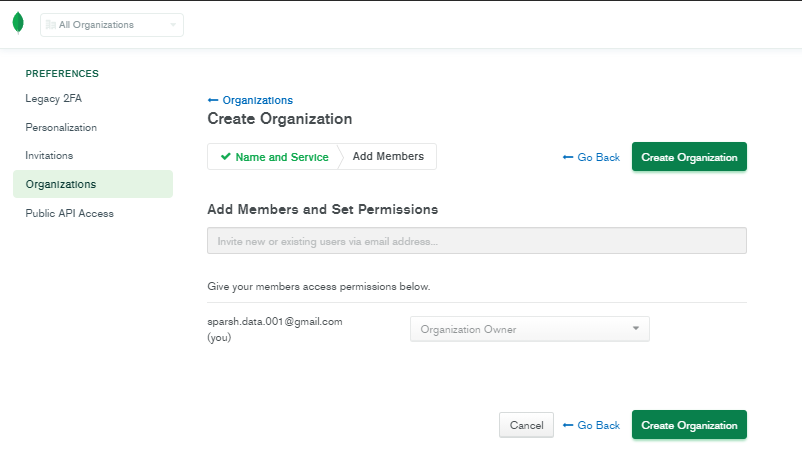

### Create a project

Click on *Create New Project*, name it and click on *Next*:

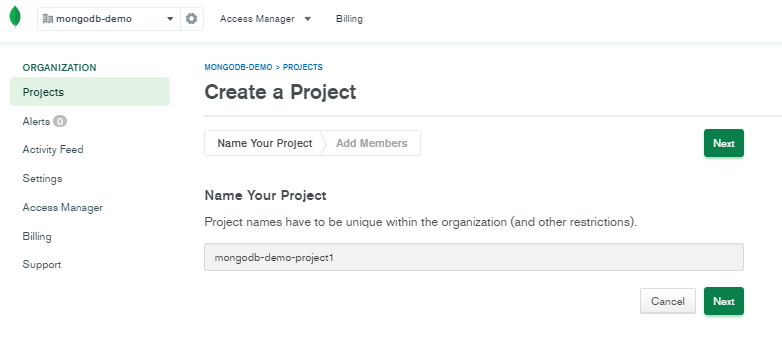

Then, click on *Create Project*:

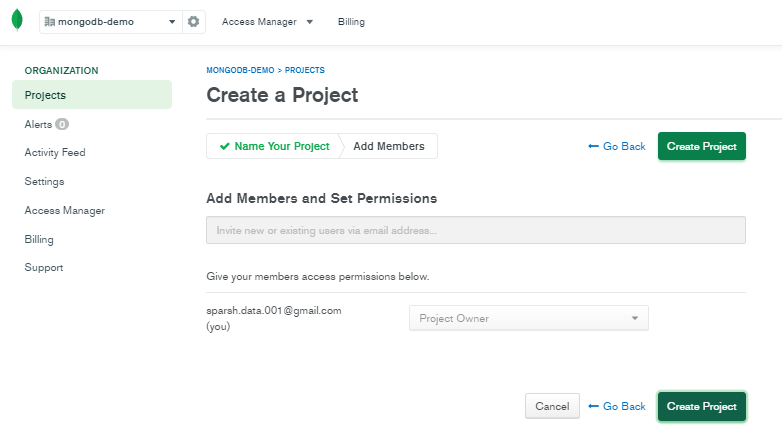

### Create a cluster

Click on *Build a Cluster*:

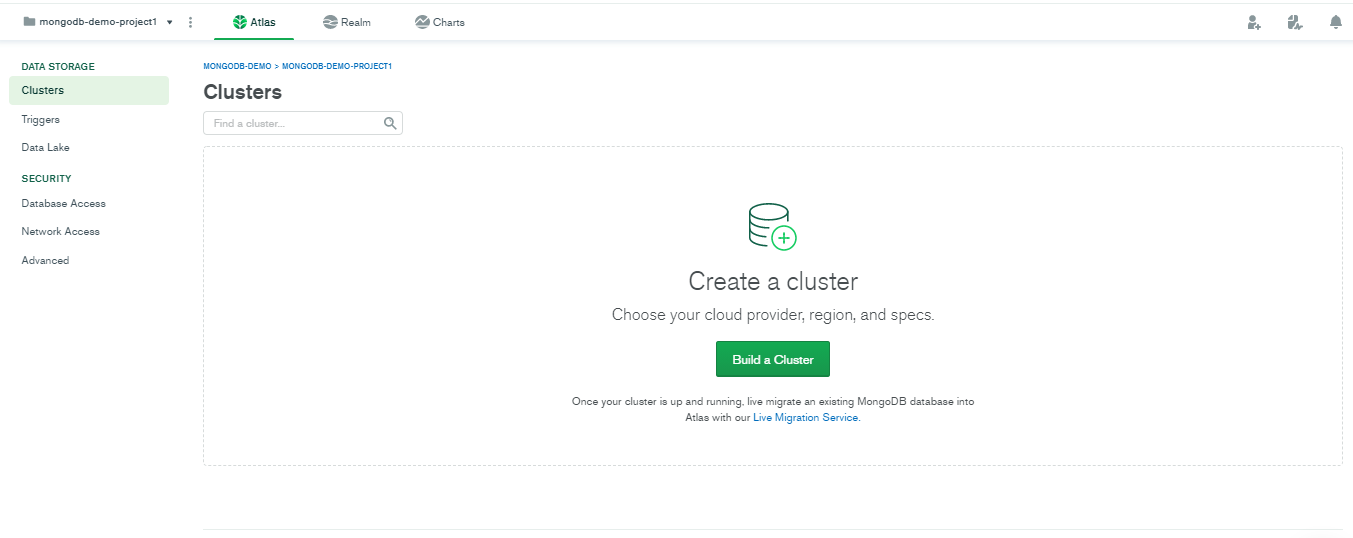

Choose the free version:

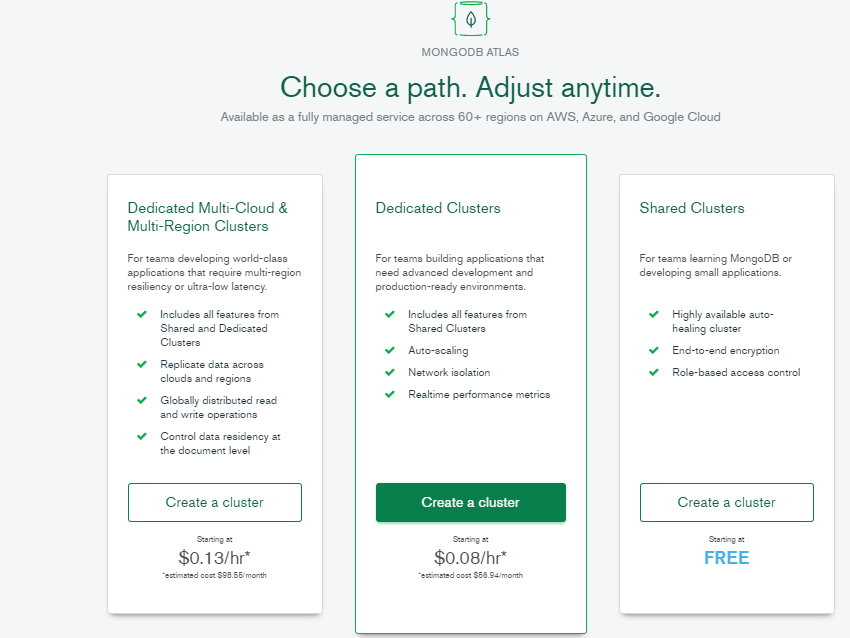

Click on *Create Cluster*:

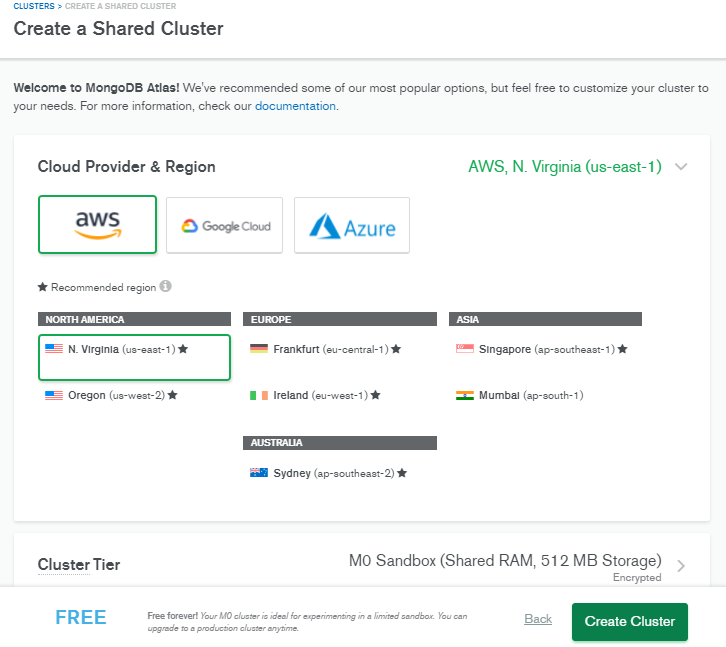

### Configure user

Click on *CONNECT* button and select *Connect from anywhere.* A default IP 0.0.0.0 will come and click Ok. 

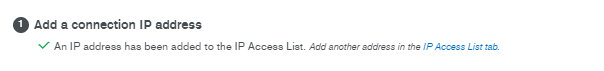

Click on *Connect* and enter username and password:

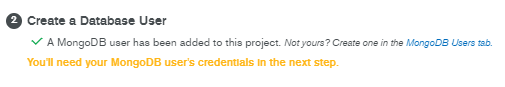

Also get the connection string that we will use in our python notebook code to connnect:

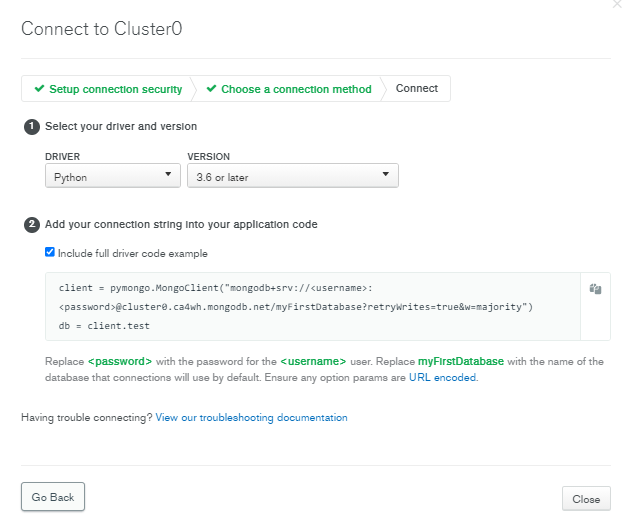

### Create a database

Click on *COLLECTIONS*, the third button on center-left of this image:

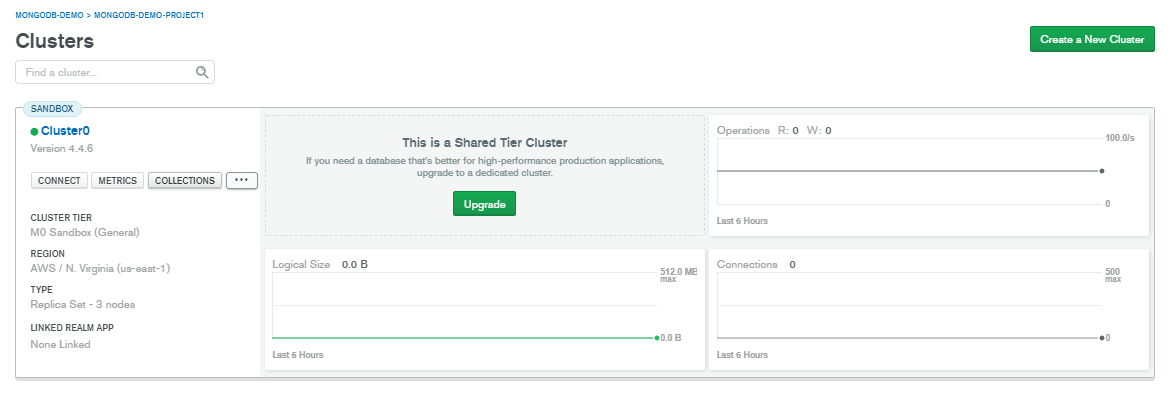

Click on *Add My Own Data* and Create the *Database*:

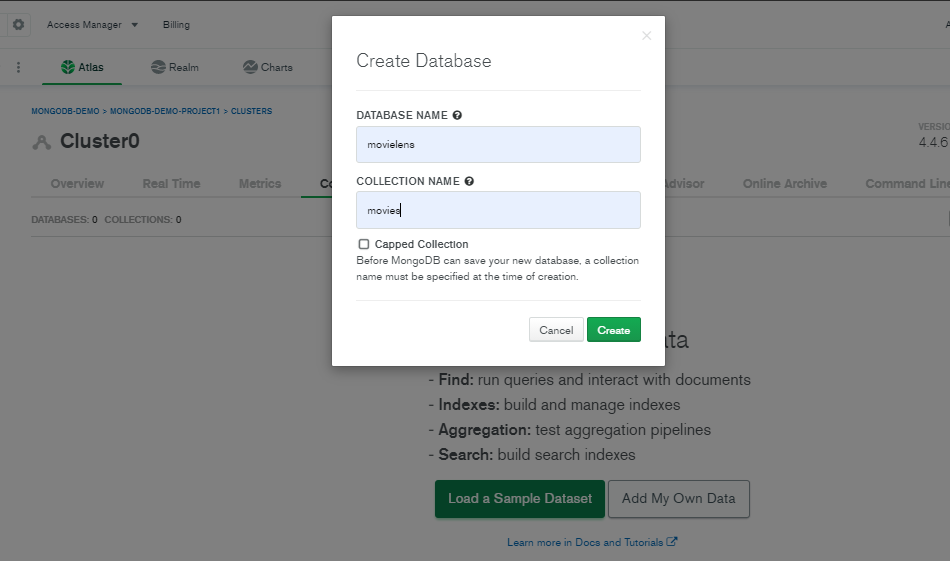

<!-- ------------------------ -->

## Kafka producer

Duration: 10

Open [this](https://nb.recohut.com/kafka/real%20time/2021/06/11/recostep-kafka-producer.html) ([mirror](https://nbviewer.jupyter.org/github/recohut/reco-static/blob/master/poc/kafka_mongodb_streaming/Kafka%20Producer.ipynb)) jupyter notebook in any of your favorite editor. I used Google Colab. 

### Configure Kafka credentials

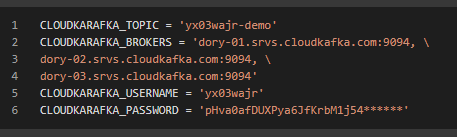

We need to get these 4 parameters from CloudKerafka account that we created. 

Once configured, we are ready to stream events to the topic server. There are 2 ways to run the stream: We can either send a fixed number of events or run a script endlessly that will ask for the message to be sent via terminal. 

In practical scenarios, we inject a javascript into the user's browser session that sends the event to a listening server and that server sends those messages to the kafka producer.

We sent 5 messages to the topic server which would look like this:

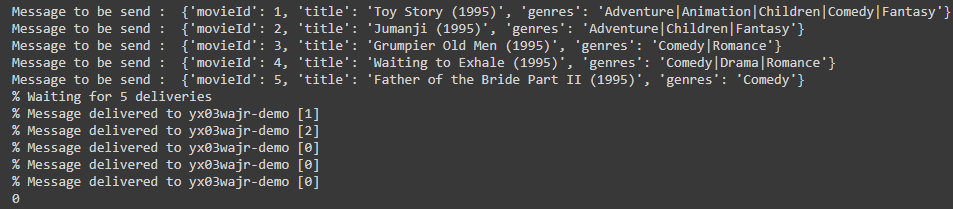

The cloudkarafka manager dashboard would look like this:

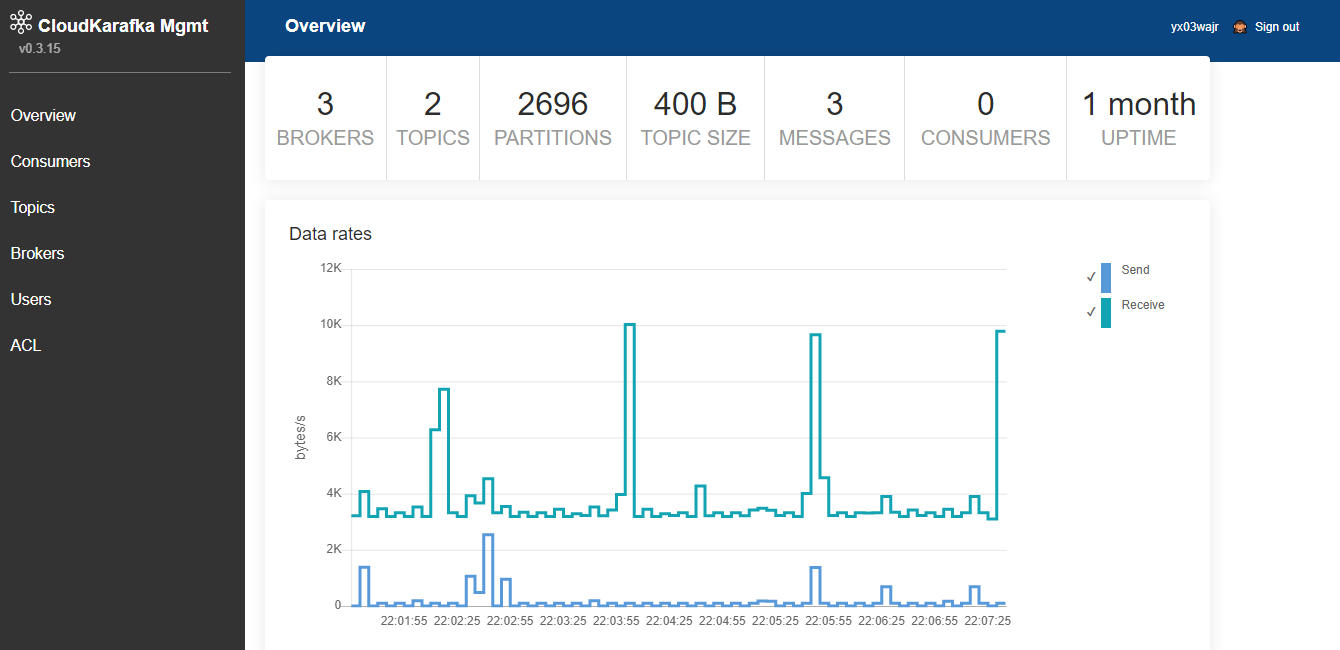

### End-to-end producer script

```python
%%writefile producer.py

import sys
import os

from confluent_kafka import Producer

CLOUDKARAFKA_TOPIC = 'yx03wajr-demo'
CLOUDKARAFKA_BROKERS = 'dory-01.srvs.cloudkafka.com:9094, \
dory-02.srvs.cloudkafka.com:9094, \
dory-03.srvs.cloudkafka.com:9094'
CLOUDKARAFKA_USERNAME = 'yx03wajr'
CLOUDKARAFKA_PASSWORD = 'pHva0afDUXPya6JfKrbM1******'

if __name__ == '__main__':
    topic = CLOUDKARAFKA_TOPIC.split(",")[0]

    # Consumer configuration
    # See https://github.com/edenhill/librdkafka/blob/master/CONFIGURATION.md
    conf = {
      'bootstrap.servers': CLOUDKARAFKA_BROKERS,
      'session.timeout.ms': 6000,
      'default.topic.config': {'auto.offset.reset': 'smallest'},
      'security.protocol': 'SASL_SSL',
      'sasl.mechanisms': 'SCRAM-SHA-256',
      'sasl.username': CLOUDKARAFKA_USERNAME,
      'sasl.password': CLOUDKARAFKA_PASSWORD
      }

    p = Producer(**conf)

    def delivery_callback(err, msg):
        if err:
            sys.stderr.write('%% Message failed delivery: %s\n' % err)
        else:
            sys.stderr.write('%% Message delivered to %s [%d]\n' %
                             (msg.topic(), msg.partition()))

    for line in sys.stdin:
        try:
            p.produce(topic, line.rstrip(), callback=delivery_callback)
        except BufferError as e:
            sys.stderr.write('%% Local producer queue is full (%d messages awaiting delivery): try again\n' %
                             len(p))
        p.poll(0)

    sys.stderr.write('%% Waiting for %d deliveries\n' % len(p))
    p.flush()
```

<!-- ------------------------ -->

## Kafka consumer and mongodb

Duration: 10

Open [this](https://nb.recohut.com/mongodb/kafka/real%20time/2021/06/11/recostep-kafka-consumer-mongodb.html) ([mirror](https://nbviewer.jupyter.org/github/recohut/reco-static/blob/master/poc/kafka_mongodb_streaming/Kafka%20Producer.ipynb)) jupyter notebook in any of your favorite editor. I used Google Colab. 

### Configure Kafka credentials

Configuration process is same as previous step.

Once configured, the received messages would look like this:


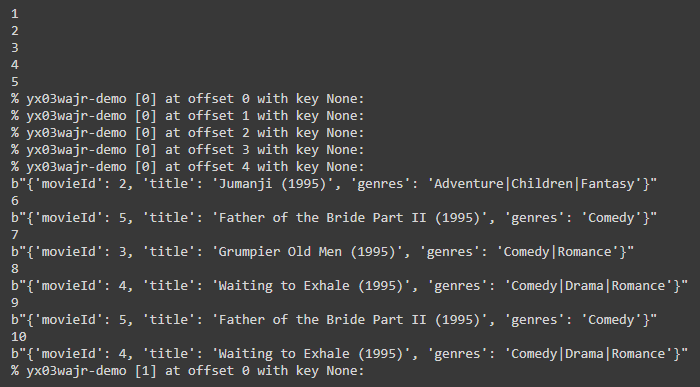

We are able to successfully receive the messages in real-time.

### Configure MongoDB

Now, let's store these messages in a persistent database. We are using MongoDB for that.

Enter these 4 parameters that we received during mongoDB configuration:

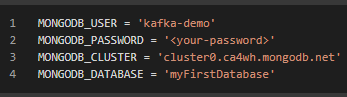

### End-to-end consumer + mongodb script

```python
%%writefile consumer.py

import sys
import os

from confluent_kafka import Consumer, KafkaException, KafkaError
import pymongo

CLOUDKARAFKA_TOPIC = 'yx03wajr-demo'
CLOUDKARAFKA_BROKERS = 'dory-01.srvs.cloudkafka.com:9094, \
dory-02.srvs.cloudkafka.com:9094, \
dory-03.srvs.cloudkafka.com:9094'
CLOUDKARAFKA_USERNAME = 'yx03wajr'
CLOUDKARAFKA_PASSWORD = 'pHva0afDUXPya6JfKrbM1j549G*****'

MONGODB_USER = 'kafka-demo'
MONGODB_PASSWORD = '<your-pass>'
MONGODB_CLUSTER = 'cluster0.ca4wh.mongodb.net'
MONGODB_DATABASE = 'movielens'

mongo_uri = f"mongodb+srv://{MONGODB_USER}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?retryWrites=true&w=majority"
client = pymongo.MongoClient(mongo_uri)
mydb = client[MONGODB_DATABASE]
movies = mydb.movies

if __name__ == '__main__':
    topics = CLOUDKARAFKA_TOPIC.split(",")

    # Consumer configuration
    # See https://github.com/edenhill/librdkafka/blob/master/CONFIGURATION.md
    conf = {
        'bootstrap.servers': CLOUDKARAFKA_BROKERS,
        'group.id': "%s-consumer" % CLOUDKARAFKA_USERNAME,
        'session.timeout.ms': 6000,
        'default.topic.config': {'auto.offset.reset': 'smallest'},
        'security.protocol': 'SASL_SSL',
        'sasl.mechanisms': 'SCRAM-SHA-256',
        'sasl.username': CLOUDKARAFKA_USERNAME,
        'sasl.password': CLOUDKARAFKA_PASSWORD
    }

    c = Consumer(**conf)
    c.subscribe(topics)
    try:
        while True:
            msg = c.poll(timeout=1.0)
            if msg is None:
                continue
            if msg.error():
                # Error or event
                if msg.error().code() == KafkaError._PARTITION_EOF:
                    # End of partition event
                    sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                     (msg.topic(), msg.partition(), msg.offset()))
                elif msg.error():
                    # Error
                    raise KafkaException(msg.error())
            else:
                # Proper message
                sys.stderr.write('%% %s [%d] at offset %d with key %s:\n' %
                                 (msg.topic(), msg.partition(), msg.offset(),
                                  str(msg.key())))
                print(msg.value())
                try:
                  movies.insert_one(eval(msg.value().decode('utf-8')))
                except:
                  movies.insert_one({"err_flag":True, "msg":str(msg.value())})

    except KeyboardInterrupt:
        sys.stderr.write('%% Aborted by user\n')

    # Close down consumer to commit final offsets.
    c.close()
```

<!-- ------------------------ -->

## MongoDB listener

Duration: 5

Open [this](https://nb.recohut.com/mongodb/real%20time/2021/06/11/recostep-mongodb-listener.html) ([mirror](https://nbviewer.jupyter.org/github/recohut/reco-static/blob/master/poc/kafka_mongodb_streaming/Kafka%20Producer.ipynb)) jupyter notebook in any of your favorite editor. I used Google Colab. 

On every message that we are receiving from Kafka, we are storing it in MongoDB. A more efficient process is to store in batch. Here is the side-by-side notebook snapshot of the entire process. Left is the producer who is sending the JSON to Kafka broker, the center is the consumer who is subscribed to the topic and receiving the messages in real-time. And on the right side, we have a MongoDB listener which is connected to MongoDB, listening to the events and converting them into a pandas data frame. 


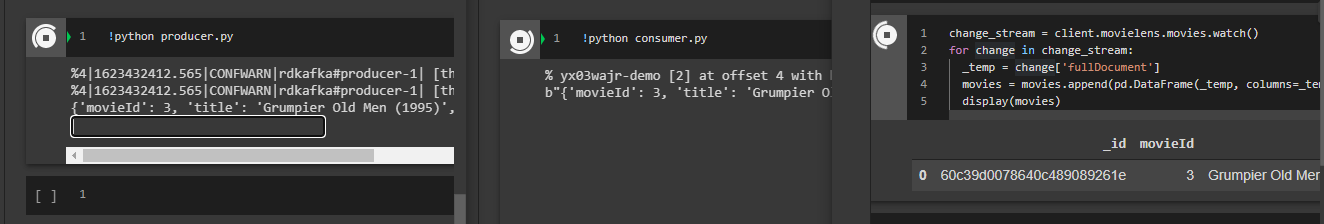

## Conclusion

Duration: 2

Congratulations! You have successfully completed the first step in building a real-time recommendation system. 

### What we've covered

- Loaded and preprocessed movielens dataset
- Trained and compared 4 versions of neural net models using tensorflow keras

### Next steps

- Build a recommender model on the data that we received from mongodb stream
- We can create a batch of let's say 10 records to update the model parameters or keep updating these parameters on every single record

### Links and References

- [Notebooks](https://github.com/recohut/reco-static/tree/master/poc/kafka_mongodb_streaming)
- [Video demo](https://youtu.be/AMY-o4ArW7E)